# Chapter 7 Moving Beyond Linearity

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf

### 7.8.1 Polynomial Regression and Step Functions

In [20]:
wage_data = pd.read_csv('Data/Wage.csv')
age = wage_data.age
wage = wage_data.wage

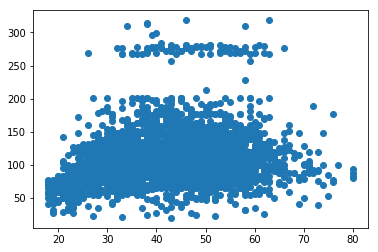

In [21]:
plt.scatter(age, wage)
plt.show()

In [22]:
X4 = PolynomialFeatures(4).fit_transform(age.values.reshape(-1,1))

In [23]:
regr = LinearRegression()
regr.fit(X = X4, y = wage)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

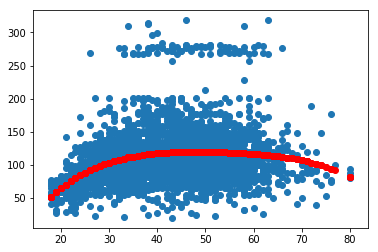

In [24]:
pred = regr.predict(X4)
plt.scatter(age, wage)
plt.scatter(age, pred, c='r')
plt.show()

In [25]:
X1 = PolynomialFeatures(1).fit_transform(age.values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(age.values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(age.values.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(age.values.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(age.values.reshape(-1,1))

# Polynomial regression model of degree 4
fit = sm.GLS(wage, X4).fit()
fit.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


In [26]:
# ANOVA
fit_1 = sm.GLS(wage, X1).fit()
fit_2 = sm.GLS(wage, X2).fit()
fit_3 = sm.GLS(wage, X3).fit()
fit_4 = sm.GLS(wage, X4).fit()
fit_5 = sm.GLS(wage, X5).fit()


sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1)

/Users/collinprather/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/collinprather/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/collinprather/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


According to the F-statistic, the polynomial degree 4 seems the best.

In [31]:
X = X4
y = (wage > 250).map({False:0, True:1}).values

As [Jordi Warmenhoven points out](https://github.com/JWarmenhoven/ISLR-python/blob/master/Notebooks/Chapter%207.ipynb): Scikit-learn implements a regularized logistic regression model particularly suitable for high dimensional data. Since we just have one feature (age) we use the GLM model from statsmodels.

In [32]:
clf = sm.GLM(y, X, family=sm.families.Binomial(sm.families.links.logit))
fit = clf.fit()

In [35]:
# creates ages for plotting and predicting
age_grid = np.arange(age.min(), age.max()).reshape(-1,1)

# Transform features to polynomial degree 4, and make predictions
X_test = PolynomialFeatures(4).fit_transform(age_grid)
pred = fit.predict(X_test)

Text(0.5,1,'Pr(wage>250|age)')

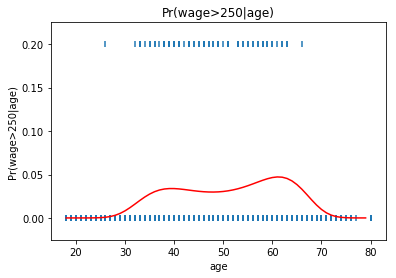

In [53]:
plt.scatter(age, y/5, marker='|') # I used y/5 because the book also did on page 292
plt.plot(age_grid, pred, color='r')
plt.xlabel('age')
plt.ylabel('Pr(wage>250|age)')
plt.title('Pr(wage>250|age)')

#### Step Function

In [55]:
age_cut, bins = pd.cut(age, 4, retbins=True, right=True)
age_cut.value_counts(sort=False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

In [57]:
df_steps = pd.concat([age, age_cut, wage], keys=['age', 'age_cuts', 'wage'], axis=1)
df_steps.head(4)

,age,age_cuts,wage
0,18,"(17.938, 33.5]",75.043154
1,24,"(17.938, 33.5]",70.476020
2,45,"(33.5, 49.0]",130.982177
3,43,"(33.5, 49.0]",154.685293


In [60]:
# Creating dummy variables for the age cuts
df_steps_dummies = pd.get_dummies(df_steps.age_cuts)

# Add the constant column (intercept term)
df_steps_dummies = sm.add_constant(df_steps_dummies)

df_steps_dummies.head(4)

,const,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1.0,1,0,0,0
1,1.0,1,0,0,0
2,1.0,0,1,0,0
3,1.0,0,1,0,0


In [63]:
# The age<33.5 is left out so that the intercept coefficient can be interpreted as the average salary for those under 33.
fit2 = sm.GLM(df_steps.wage, df_steps_dummies.drop(df_steps_dummies.columns[1], axis=1)).fit()
fit2.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.265,97.051
"(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.468,27.639
"(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.611,27.718
"(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.135,17.416
